# **Classification par CNN images poumons. Implémentation Keras (Tensorflow)**

## **<span style="color:blue"> Part 1: Definition de l'architecture des CNN </span>**

In [2]:
# Import des modules et bibliothèques
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

from utils import *
from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### **<span style="color:blue">  Data Pre-processing automatisé </span>**


In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 2.6.0
Keras version = 2.6.0


In [9]:
# NOMS POUR REPERTOIRES
TRAIN_DIR = 'data/train'
VALID_DIR = 'data/val'
TEST_DIR = 'data/test'
l_DIRS = [TRAIN_DIR, VALID_DIR, TEST_DIR]
POSITIVE_CLASS = 'NORMAL'
ABSTRACT_CLASS = 'PNEUMONIA'

# CONSTANTES POUR LES PARAMETRES D'IMAGE
INPUT_W = 1200 # pixels
INPUT_H = 900  # pixels
DIVIDER = 3.6
INPUT_DIM = (int(INPUT_W/DIVIDER), int(INPUT_H/DIVIDER), 1)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64 
BATCH_SIZE_VALID = 16
NORMALIZER = 1./255
IMAGE_FORMAT = 'jpeg'

# Infos sorties
print('Dimensions de l\'image pour le CNN = {}'.format(INPUT_DIM))

Dimensions de l'image pour le CNN = (333, 250, 1)


In [10]:
if abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
    structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(l_DIRS)

print('Classes trouvées pour le modèle:\n{}'.format(classes))

Les données sont valides et peuvent être passées en entrée au modèle.

Classes trouvées pour le modèle:
{'TRAIN': ['BACTERIA', 'NORMAL', 'VIRUS'], 'VALIDATION': ['BACTERIA', 'NORMAL'], 'TEST': ['BACTERIA', 'NORMAL', 'VIRUS']}


Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 16 images belonging to 2 classes.


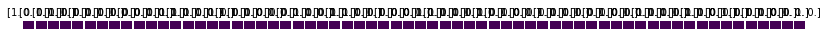

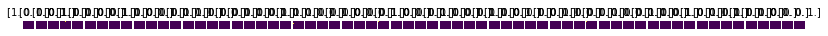

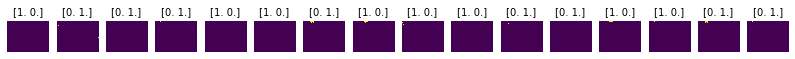

In [6]:
# Generation d'images du Train Set et plot
TRAIN_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TRAIN_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TRAIN'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TRAIN)

imgs, labels = next(TRAIN_BATCHES)  # <-- Extraction des matrices des images et des labels
plots(imgs, titles=labels)          # <-- Plot images avec les labels
#train_imgs = rgb_to_grayscale(imgs) # <-- Convertion images RGB en Noir et blanc 
#train_labels = labels

# Generation d'images du Test Set et plot
TEST_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TEST_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TEST'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TEST)

imgs, labels = next(TEST_BATCHES)   # <-- Extraction des matrices des images et des labels
plots(imgs, titles=labels)          ## <-- Plot images avec les labels
#test_imgs = rgb_to_grayscale(imgs)  # <-- Convertion images RGB en Noir et blanc 
#test_labels = labels

# Generation d'images du Validation Set et plot
VAL_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(VALID_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['VALIDATION'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_VALID)

imgs, labels = next(VAL_BATCHES)   # <-- Extraction des matrices des images et des labels
plots(imgs, titles=labels)         # <-- Plot images avec les labels
#val_imgs = rgb_to_grayscale(imgs)  # <-- Convertion images RGB en Noir et blanc 
#val_labels = labels

In [8]:
# Sorties du generateurs d'images
for data_batch, label_batch in TRAIN_BATCHES:
    print('data batch shape = {}'.format(data_batch.shape))
    print('labels batch shape = {}'.format(label_batch.shape))
    break



data batch shape = (64, 333, 250, 1)
labels batch shape = (64, 3)


### **<span style="color:blue">  Architecture CNN (Keras)</span>**


In [11]:
# Constuction du modèle CNN
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(INPUT_DIM)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (4, 4))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.02))) 
model.add(Activation('relu'))

model.add(Dense(3)) 
model.add(Activation('softmax'))



2021-09-15 03:25:15.511515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-15 03:25:15.511539: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-15 03:25:15.511559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stankoua-NUC10i7FNH): /proc/driver/nvidia/version does not exist
2021-09-15 03:25:15.511765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 329, 246, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 329, 246, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 82, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 79, 128)      131200    
_________________________________________________________________
activation_1 (Activation)    (None, 106, 79, 128)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 39, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 37, 512)       5

In [13]:
# Define an optimizer for the model
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.85, nesterov=True)
#opt = RMSprop(lr=0.001, rho=0.8, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [14]:
print('steps_per_epoch={}'.format(int(5215 / BATCH_SIZE_TRAIN)))
print('validation_steps={}'.format(int(624 / BATCH_SIZE_TEST)))

steps_per_epoch=81
validation_steps=9


### **<span style="color:blue"> Entrainement du CNN sur le Training set </span>**


In [15]:
%%time
model.fit_generator(
    TRAIN_BATCHES,
    steps_per_epoch=len(TRAIN_BATCHES),
    validation_data=TEST_BATCHES,
    validation_steps=len(TEST_BATCHES),
    epochs=100,
    verbose=2
)

# Paramètres:
# steps_per_epoch = nombre d'images / batch_size = 5215 / 64 = 82:
# --- Nombre total d'étapes (batches des samples) à renvoyer du generateur avant de passer à l'epoch suivante. 
#     Il doit être égal au nombre unique de samples de notre data set divisé par le batch size.
# Verbose:
# -- 0 (quiet): affiche juste le nombre total des tests executés et le résultat global
# -- 1 (default): pareil que le verbose 0. Affiche juste en plus un point pour chaque test reussis ou un F pour chaque echec
# -- 2 (verbose): Une ligne par epoch; affiche le résultat de chaque test. 

2021-09-15 03:33:09.043623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-09-15 03:33:10.075330: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1326022656 exceeds 10% of free system memory.
2021-09-15 03:33:10.363608: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 146440192 exceeds 10% of free system memory.
2021-09-15 03:33:10.446736: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 274399232 exceeds 10% of free system memory.
2021-09-15 03:33:10.803639: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67731456 exceeds 10% of free system memory.
2021-09-15 03:33:10.824817: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 247332864 exceeds 10% of free system memory.


82/82 - 566s - loss: 11.1241 - accuracy: 0.4850 - val_loss: 10.9976 - val_accuracy: 0.3878
Epoch 2/100
82/82 - 564s - loss: 10.7797 - accuracy: 0.4850 - val_loss: 10.6644 - val_accuracy: 0.3878
Epoch 3/100
82/82 - 571s - loss: 10.3925 - accuracy: 0.5518 - val_loss: 10.2155 - val_accuracy: 0.5721
Epoch 4/100
82/82 - 568s - loss: 9.9367 - accuracy: 0.6522 - val_loss: 9.8108 - val_accuracy: 0.6138
Epoch 5/100
82/82 - 559s - loss: 9.5954 - accuracy: 0.6643 - val_loss: 9.5078 - val_accuracy: 0.6202
Epoch 6/100
82/82 - 553s - loss: 9.2991 - accuracy: 0.6858 - val_loss: 9.2254 - val_accuracy: 0.6667
Epoch 7/100
82/82 - 544s - loss: 9.0356 - accuracy: 0.6915 - val_loss: 9.0341 - val_accuracy: 0.6282
Epoch 8/100
82/82 - 540s - loss: 8.7625 - accuracy: 0.7155 - val_loss: 8.7509 - val_accuracy: 0.7163
Epoch 9/100
82/82 - 540s - loss: 8.5195 - accuracy: 0.7278 - val_loss: 8.4490 - val_accuracy: 0.6747
Epoch 10/100
82/82 - 543s - loss: 8.2765 - accuracy: 0.7333 - val_loss: 8.3816 - val_accuracy: 0.

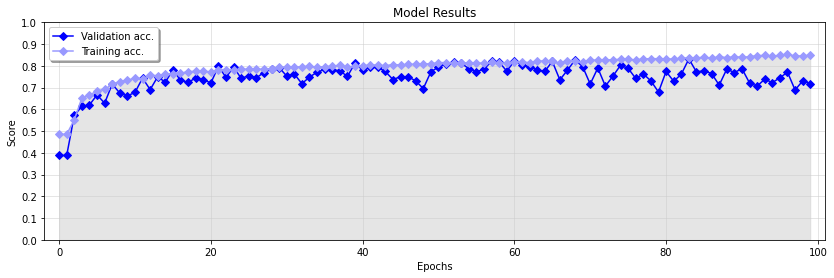

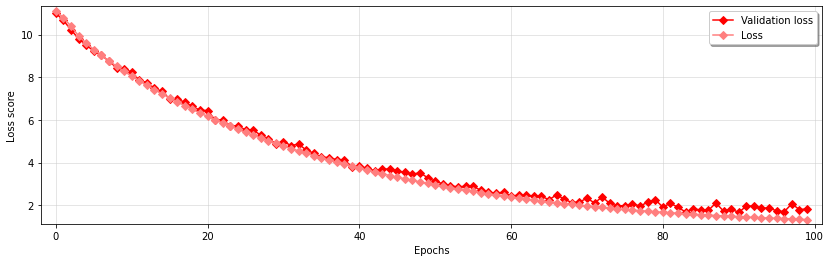

In [39]:
from utils2 import *
plot_model_result(model)

In [40]:
# Sauvegarde des resultas 
df = save_model_result(model)

     val_acc       acc   val_loss       loss
0   0.387821  0.485046  10.997593  11.124081
1   0.387821  0.485046  10.664424  10.779655
2   0.572115  0.551764  10.215453  10.392471
3   0.613782  0.652224   9.810766   9.936707
4   0.620192  0.664302   9.507759   9.595383
..       ...       ...        ...        ...
95  0.745192  0.848159   1.738993   1.387802
96  0.770833  0.852569   1.702279   1.373785
97  0.689103  0.846051   2.074942   1.365471
98  0.730769  0.845092   1.798116   1.351321
99  0.717949  0.849310   1.836467   1.331299

[100 rows x 4 columns]


Les résultat du modèle sont sauvegardés dans le fichier: model_results_2021-09-15_19-19.csv


## **<span style="color:blue"> Part 2 : Export du modèle et ouverture pour le deploiement (Flask)</span>**

In [46]:
# Sauvegarde des poids du Modèle 
model.save_weights('cnn_model_100_epochs_adam_20210915.h5')

# Sauvegarde du Modèle en format JSON
model_json = model.to_json()
with open('cnn_model_adam_20210915.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Modèle Sauvegardé en local (sur le disque)')

Modèle Sauvegardé en local (sur le disque)


In [43]:
# ------------------------------------------------------------------------
# Chargement et sauvegarde du modèle et de ses poids
'''
    Les poids du modèle sont sauvegardé au format HDF5.
    La structure du modèle peut être décrite et sauvegardée en utilisant 2 formats differents: JSON and YAML.
'''

# Import des dépendances
#from keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()
import h5py 
#from PIL import Image
#import PIL
#from vb100_utils import *

In [ ]:
print('la version h5py est {}'.format(h5py.__version__))

la version h5py est 3.1.0


In [50]:
import os
os.path.realpath('.')
Documents/Ralph/Projects/AI_Pneumonie_FlaskxCGP/cnn_model_100_epochs_adam_20210915.h5

'/home/stankoua/Documents/Ralph/Projects/AI_Pneumonie_FlaskxCGP'

In [ ]:
import os
PATH = os.path.realpath('.')
PATH + '/' + '

In [51]:
# Récuperer l'architecture du CNN
json_file = open('./cnn_model_adam_20210915.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Récuperer les poids du model 
loaded_model.load_weights('./cnn_model_100_epochs_adam_20210915.h5')

In [76]:
INPUT_DIM

(333, 250, 1)

In [83]:
'''
    Ici on va simuler ce qui va ce passer lors du déploiement sur le cloud.
    C'est à dire lire une image donnée en entrée, la préparer pour l'évaluation par le CNN
    et proposer une prédiction en retournant une classe issue du dictionnnaire qui a été utilisé pour l'entrainement.
'''

# Definition de l'optimiseur et compilation du modèle 
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')


'''
    Attention ! Pour ce block l'optimiseur est entré manuellement (rmsprop) comme un objet Tensorflow.
    Pour le future, il faut le changer pour l'inclure comme une variable avec un ensemble de paramètres 
    vu cette fois ci comme une variable Tensorflow.

'''

IMG = Image.open('data/val/BACTERIA/person1947_bacteria_4876.jpeg')
print(type(IMG))
IMG = IMG.resize((333, 250))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(1, 333, 250, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = np.argmax(predictions,axis=1)
print(predictions, predictions_c)


<class 'PIL.JpegImagePlugin.JpegImageFile'>
po array = (250, 333)
<class 'numpy.ndarray'> (1, 333, 250, 1)
[[6.2722205e-03 2.6378766e-04 9.9346393e-01]] [2]


In [84]:
classes = {'TRAIN': ['BACTERIA', 'NORMAL', 'VIRUS'],
           'VALIDATION': ['BACTERIA', 'NORMAL'],
           'TEST': ['BACTERIA', 'NORMAL', 'VIRUS']}

predicted_class = classes['TRAIN'][predictions_c[0]]
print('Prédiction du modèle : {}.'.format(predicted_class.lower()))

Prédiction du modèle : virus.
